# 4. Nuclear phylogenomics
## 4.1 Determine number of incongruent phylogenetic patterns in orthology clusters

This will compute a raxml tree for each orthology cluster, compute pairwise distances among the trees and run a metric MDS to check how many clusters of trees there are. Only one tight cluster is observed.

/home/amir/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Loading files: 533 of 533 |###############| Elapsed Time: 0:00:04 Time: 0:00:04
Raxml Tree estimation: 533 of 533 |#######| Elapsed Time: 0:07:16 Time: 0:07:16



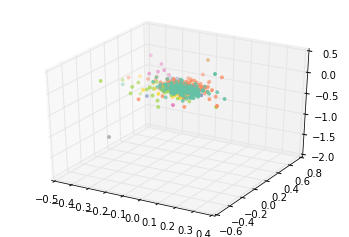

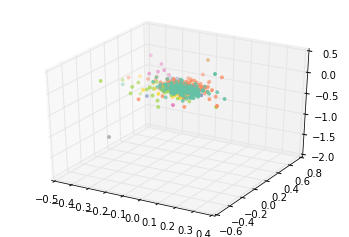

In [1]:
import treeCl, glob, os

# All the orthology cluster in which at lease three reference samples
# have two copies, and all the reference samples have at least one copy
alndir = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'

for f in glob.glob(alndir+'/*.fasta'):
    newf = f.replace('RAxML_bestTree.','').replace('207161484757013.97_','')
    os.rename(f, newf)

# Compute gene trees
c = treeCl.Collection(input_dir=alndir, file_format='fasta')
c.calc_trees(executable='raxmlHPC-PTHREADS',  # specify raxml binary to use
             threads=14,  # use multithreaded raxml
             model='GTRGAMMA',  # this model of evolution
             fast_tree=False)

# Compute pairwise distance between gene trees using a 
# weighted robinson foulds distance
dm = c.get_inter_tree_distances('wrf')

# Metric MDS, impose 10 clusters
mdsclust = treeCl.MultidimensionalScaling(dm)
mds_partitions = mdsclust.cluster(10)
mds_mmds = mdsclust.dm.embedding(3, 'mmds')
%matplotlib inline
treeCl.plotter.plot_embedding(mds_mmds,
                              partition=mds_partitions, 
                              add_sphere=False, 
                              legend=False,
                              outfile=alndir + '/metric_mds.png')

## 4.2 Automatically detect the number of clusters using DBS
With esp ranging from 0.01 to 0.75, only the esp == 0.1 produces more than one cluster. One cluster with 406 trees and another with 39 trees.

In [2]:
aclust = treeCl.Automatic(dm)
# esp was 0.75 - 0.01. Only esp == 0.1 gives more than one cluster.
dbscan_partitions = aclust.dbscan(eps=0.1, min_samples=3)

In [3]:
dbscan_clustlengths = [len(i) for i in list(dbscan_partitions)]
print 'dbs_clusters', dbscan_clustlengths

dbs_clusters [496, 37]


## 4.3 Build a thorough RAxML tree for merged DBS clusters
Because the two cluster trees have the same topology, they can be merged

In [3]:
from Bio import SeqIO, AlignIO

alndir = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'

md5_1 = '08389aebb98087519807222b39cb6f4ed8714036'
matrix_from_treeCl_cache_1 = alndir.replace('alns','cache_alignments') + '/%s.phy' % md5_1

c1 = SeqIO.to_dict(SeqIO.parse(matrix_from_treeCl_cache_1,'phylip'))

md5_0 = 'c1f0e70d6f3c2981d39ed286cd30d69eb733f952'
matrix_from_treeCl_cache_0 = alndir.replace('alns','cache_alignments') + '/%s.phy' % md5_0

with open(alndir+'/merged_clusters.phy', 'wt') as hndl:
    hndl.write('38 568839\n')
    for r in AlignIO.read(matrix_from_treeCl_cache_0, 'phylip-relaxed'):
        r.seq += c1[r.id].seq
        hndl.write("%s %s\n" % (r.id, str(r.seq)))
    

with open(alndir+'/merged_clusters.parts', 'wt') as hndl:
    parts_from_treeCl_cache_0 = alndir.replace('alns','cache_alignments') + '/%s.partitions.txt' % md5_0
    hndl.write(open(parts_from_treeCl_cache_0,'r').read())
    last = int(open(parts_from_treeCl_cache_0,'r').readlines()[-1].rstrip().split('-')[-1])
    parts_from_treeCl_cache_1 = alndir.replace('alns','cache_alignments') + '/%s.partitions.txt' % md5_1
    for l in open(parts_from_treeCl_cache_1,'r'):
        modelgene = l.rstrip().split(' = ')[0]
        start, end = [int(i) for i in l.rstrip().split(' = ')[1].split('-')]
        hndl.write("%s = %i-%i\n" % (modelgene, start+last, end+last))

<pre>
#!/bin/bash
#SBATCH -J raxml
#SBATCH -N 1
#SBATCH --ntasks-per-node 1
#SBATCH -o ./phylo.out
#SBATCH -e ./phylo.err
#SBATCH -p highmem
#SBATCH --exclusive


module add gcc/4.9.3

/home/myViperUser/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-s 13132e5831e469c5c387672baf3656f29252e4e9.phy \
-q 13132e5831e469c5c387672baf3656f29252e4e9.partitions.txt \
-m GTRGAMMA \
-p 123 \
-N 100 \
-n 13132e5831e469c5c387672baf3656f29252e4e9_0 \
-T 40 \
&& \
/home/myViperUser/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-s 13132e5831e469c5c387672baf3656f29252e4e9.phy    \
-q 13132e5831e469c5c387672baf3656f29252e4e9.partitions.txt \
-m GTRGAMMA \
-b 789 \
-p 123 \
-N 100 \
-n 13132e5831e469c5c387672baf3656f29252e4e9_1 \
-T 40 \
&& \
/home/myViperUser/standard-RAxML-master/raxmlHPC-PTHREADS-SSE3 \
-f b \
-s 13132e5831e469c5c387672baf3656f29252e4e9.phy \
-t RAxML_bestTree.13132e5831e469c5c387672baf3656f29252e4e9_0 \
-z RAxML_bootstrap.13132e5831e469c5c387672baf3656f29252e4e9_1 \
-m GTRGAMMA \
-n 13132e5831e469c5c387672baf3656f29252e4e9_2 \


module purge


</pre>

# Figure 3

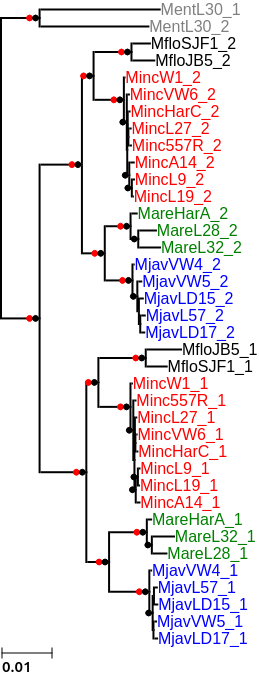

In [30]:
from ete2 import * 

ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
ts.show_leaf_name=False

colors = {
    'Minc': 'red',
    'Mjav': 'blue',
    'Mflo': 'black',
    'Mare': 'green',
    'Ment': 'gray'
}

alndir = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'
treefile = alndir+'/RAxML_bipartitions.merged_clusters_2'

t = Tree(treefile)
t.dist = 0
t.set_outgroup(t.get_common_ancestor('MincL17_1','MincL15_1'))
t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
    
t.children = sorted(t.children) 

#(t&'MfloJB5_2').up.up.up.children = sorted( (t&'MfloJB5_2').up.up.up.children, reverse=True)
#(t&'MfloJB5_2').up.up.children = sorted( (t&'MfloJB5_2').up.up.children, reverse=True)
#(t&'MfloJB5_1').up.up.children = sorted( (t&'MfloJB5_1').up.up.children, reverse=True)
#(t&'MareL32_2').up.up.up.children = sorted( (t&'MareL32_2').up.up.up.children,  reverse=True)

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD15')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')
    elif n.support == 100:
        n.add_face(CircleFace(3, 'black'),1,position='float')

    n.set_style(ns)
    
red_bulets = [
    t.get_common_ancestor('MentL30_1','MentL30_2'),
    t.get_common_ancestor('MincW1_1','MincVW6_1'),
    t.get_common_ancestor('MincW1_2','MincVW6_2'),
    t.get_common_ancestor('MfloJB5_1','MfloSJF1_1'),
    t.get_common_ancestor('MfloJB5_2','MfloSJF1_2'),
    t.get_common_ancestor('MjavVW4_1','MjavL57_1'),
    t.get_common_ancestor('MjavVW4_2','MjavL57_2'),
    t.get_common_ancestor('MareHarA_1','MareL32_1'),
    t.get_common_ancestor('MareHarA_2','MareL32_2'),
    t.get_common_ancestor('MjavVW4_1','MareHarA_1'),
    t.get_common_ancestor('MjavVW4_2','MareHarA_2'),
    t.get_common_ancestor('MjavVW4_1','MincW1_1'),
    t.get_common_ancestor('MjavVW4_2','MincW1_2'),
    t.get_common_ancestor('MincW1_1','MincW1_2'),
    t.get_common_ancestor('MincW1_1','MfloSJF1_1'),
    t.get_common_ancestor('MincW1_2','MfloSJF1_2')
]

for n in red_bulets:
    n.add_face(CircleFace(3, 'red'),0,position='float')
    
t.render(alndir+'/raxml_merged_clusters.png',tree_style=ts, w=5000 ,dpi=900)
t.render('%%inline',tree_style=ts)

## 4.4 Shuffled raxml consensus
100 randomized supermatrices of cluster where in each gene partition, each homeologue is randomly assigned to the first or the second homeologue.

In [11]:
from Bio import SeqIO
from random import shuffle
from misc import execute_cline
from os import rename, mkdir, path
import glob

alndir = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'

workdir = alndir + '/raxmlshuffled'

if not path.exists(workdir):
    mkdir(workdir)

partf=alndir+'/merged_clusters.parts'
phy=alndir+'/merged_clusters.phy'

real_seq = SeqIO.to_dict(SeqIO.parse(phy,'phylip-relaxed'))

with open(partf,'r') as lines:
    parts = []
    for line in lines:
        coords = line.rstrip().split('=')[1].strip().split('-')
        coords = [int(i) for i in coords]
        coords[0] -= 1
        parts.append(coords)

with open(workdir+'/trees.txt','wt') as all_trees:        
    repeat = 0        
    while repeat < 100:
        shuffled_dict = {key: '' for key in real_seq}
        for part in parts:
            homs = [1,2]
            shuffle(homs)
            homs = [None] + homs
            for key in shuffled_dict:
                hom_to_sample = key[:-1] + str(homs[int(key[-1])])
                shuffled_dict[key] += str(real_seq[hom_to_sample].seq)[part[0]:part[1]]

        with open(workdir + '/shuffled%i.fasta'%repeat,'wt') as hndl:
            for key in shuffled_dict:
                hndl.write('>%s\n%s\n'%(key,shuffled_dict[key]))

        raxmlcline = "raxmlHPC-PTHREADS -T 13 -s {0} -n repeat{1} -m GTRGAMMA -q {2} -p 123".format(
            workdir + '/shuffled%i.fasta'%repeat,
            repeat,
            partf
        )         
        out, err = execute_cline(raxmlcline)
        tree = open('RAxML_bestTree.repeat%i'%repeat,'r').read().rstrip()
        all_trees.write(tree+'\n')
        for f in glob.glob('RAxML_*'):
            rename(f, workdir + '/' +f)


        repeat += 1

In [12]:
con_cline = 'raxmlHPC-PTHREADS -J STRICT -z {0} -m GTRGAMMA -n RaxStrict'

out, err = execute_cline(con_cline.format(workdir+'/trees.txt'))

In [13]:
rename('RAxML_StrictConsensusTree.RaxStrict',alndir + '/RAxML_StrictConsensusTree.RaxStrict')

rename('RAxML_info.RaxStrict',alndir + '/RAxML_info.RaxStrict')

# Figure S4

In [46]:
from ete2 import *   
from re import sub

ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc': 'red',
    'Mjav': 'blue',
    'Mflo': 'black',
    'Mare': 'green',
    'Ment': 'gray'
}

raxmlf = './orthofinder/all_inputs/Results_Jan16/'
raxmlf += 'I2_3X2_gt0.7_st0.001_alns_1_4/RAxML_StrictConsensusTree.RaxStrict'

t = Tree(sub('\[\d+\]','',open(raxmlf,'r').read()))
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')
    
t.children = sorted(t.children, reverse=True) 

(t&'MfloJB5_2').up.up.children = sorted( (t&'MfloJB5_2').up.up.children, reverse=True)
(t&'MfloJB5_1').up.up.children = sorted( (t&'MfloJB5_1').up.up.children, reverse=True)
(t&'MareHarA_2').up.up.children = sorted( (t&'MareHarA_2').up.up.children, reverse=True)
(t&'MareHarA_1').up.up.children = sorted( (t&'MareHarA_1').up.up.children, reverse=True)

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD15')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
    
a=t.render(alndir+'/raxml_strict.png',tree_style=ts, w=5000,dpi=900)

In [47]:
from IPython.display import Image
Image(alndir+'/raxml_strict.png')
# A strict consensus tree of all the randomized trees

## 4.5 Astral tree

In [16]:
# Make gene trees
import glob
from subprocess import PIPE, Popen
alndir = '/home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/Homeologue_phylogenomics/'
alndir += 'orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'
with open(alndir+'/gene_trees.txt','wt') as hndl:
    for f in glob.glob(alndir+'/*.fasta'):
        gene = f.split('/')[-1].split('.')[0]
        cline = 'raxmlHPC-PTHREADS -T 12 -s %s -n %s -m GTRGAMMA -p 123' % (f, gene)
        p = Popen(cline, shell=True, stdout=PIPE, stderr=PIPE)
        out,err = p.communicate()
        tree = './RAxML_bestTree.%s'%gene
        hndl.write(open(tree,'r').read())
    

In [17]:
%%bash
# Astral tree

java -jar /home/amir/programs/ASTRAL-master/astral.4.10.6.jar \
-i /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jan16/\
I2_3X2_gt0.7_st0.001_alns_1_4/gene_trees.txt \
1> /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jan16/\
I2_3X2_gt0.7_st0.001_alns_1_4/astral.out \
2> /home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/\
Homeologue_phylogenomics/orthofinder/all_inputs/Results_Jan16/\
I2_3X2_gt0.7_st0.001_alns_1_4/astral.log \

In [60]:
from ete2 import *   

ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc': 'red',
    'Mjav': 'blue',
    'Mflo': 'black',
    'Mare': 'green',
    'Ment': 'gray'
}

astralf = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4/astral.out'

t = Tree(astralf)
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')
    
t.children = sorted(t.children, reverse=True) 

(t&'MfloJB5_2').up.up.up.children = sorted( (t&'MfloJB5_2').up.up.up.children, reverse=True)
(t&'MjavVW4_1').up.up.up.children = sorted( (t&'MjavVW4_1').up.up.up.children, reverse=True)

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD15')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
a=t.render(alndir+'/astral.png',tree_style=ts, w=5000 ,dpi=900)
#t.render('%%inline',tree_style=ts, dpi=300)

In [61]:
Image(alndir+'/astral.png')

## 4.6 Shuffeled astral consensus
Same as the randomized supermatrices, we randomize the homeologue suffix between the homeologues in the gene trees

In [ ]:
from misc import makedir, execute_cline
from random import shuffle
from ete2 import Tree
import glob
from os import rename


makedir(alndir+'/astralshuffeled')
workdir = alndir+'/astralshuffeled'
treeglob = './RAxML_bestTree.*'
astralcline = 'java -jar /home/amir/programs/ASTRAL-master/astral.4.10.6.jar '
astralcline += '-i {0}'
repeat = 0
while repeat < 100:
    astralin = workdir + '/trees%i.txt' % repeat
    with open(astralin, 'wt') as hndl:
        for f in glob.glob(treeglob):
            homs = [1,2]
            shuffle(homs)
            homs = [None] + homs
            t = Tree(f)
            for l in t:
                suffix = int(l.name[-1])
                shuffled_suffix = str(homs[suffix])
                l.name = l.name[:-1] + shuffled_suffix
            hndl.write(t.write().rstrip()+'\n')
    astralout = workdir + '/astral%i.out' % repeat
    astrallog = workdir + '/astral%i.log' % repeat
    out, err = execute_cline(astralcline.format(astralin))
    with open(astralout,'wt') as hndl:
        hndl.write(out)
    with open(astrallog,'wt') as hndl:
        hndl.write(err)
        
    repeat += 1    
    

altraltreeglob = workdir + '/astral*.out'

all_shuffled_trees = workdir + '/all_shuffled_trees.txt'
with open(all_shuffled_trees,'wt') as hndl:
    for f in glob.glob(altraltreeglob):
        hndl.write(open(f,'r').read())
        
con_cline = 'raxmlHPC-PTHREADS -J STRICT -z {0} -m GTRGAMMA -n AstStrict'

out, err = execute_cline(con_cline.format(all_shuffled_trees))


rename('RAxML_StrictConsensusTree.AstStrict',alndir + '/RAxML_StrictConsensusTree.AstStrict')

rename('RAxML_info.AstStrict',alndir + '/RAxML_info.AstStrict')

In [ ]:
from ete2 import *   
ns = NodeStyle()
ns['size'] = 0
ns['vt_line_width'] = 2
ns['hz_line_width'] = 2
ts = TreeStyle()
#ts.title.add_face(TextFace(title, fsize=20), column=0)
ts.show_leaf_name=False

colors = {
    'Minc': 'red',
    'Mjav': 'blue',
    'Mflo': 'black',
    'Mare': 'green',
    'Ment': 'gray'
}

astralf = './orthofinder/all_inputs/Results_Jan16/'
astralf += 'I2_3X2_gt0.7_st0.001_alns_1_4/RAxML_StrictConsensusTree.AstStrict'

t = Tree(open(astralf,'r').read().replace('[100]',''))
t.dist = 0
try:
    t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
except:
    t.set_outgroup('MentL30_1')

for n in t.traverse():
    if n.is_leaf():
        text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD15')

        fgcolor = 'black'
        try:
            fgcolor=colors[text[:4]]
        except:
            fgcolor = 'black'

        n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                   0,position='branch-right')

    n.set_style(ns)
    
(t&'MfloJB5_1').up.up.up.up.children = sorted( (t&'MfloJB5_1').up.up.up.up.children)
(t&'MfloJB5_2').up.up.up.children = sorted( (t&'MfloJB5_2').up.up.up.children)
(t&'MfloJB5_2').up.up.children = sorted( (t&'MfloJB5_2').up.up.children, reverse=True)
(t&'MfloJB5_1').up.up.children = sorted( (t&'MfloJB5_1').up.up.children, reverse=True)
(t&'MareL28_1').up.up.children = sorted( (t&'MareL28_1').up.up.children, reverse=True)
#(t&'MareL28_2').up.up.children = sorted( (t&'MareL28_2').up.up.children, reverse=True)
#(t&'MfloJB5_2').up.up.children = sorted( (t&'MfloJB5_2').up.up.children, reverse=True)
#(t&'MjavVW4_1').up.up.up.children = sorted( (t&'MjavVW4_1').up.up.up.children, reverse=True)

a=t.render(alndir+'/astral_strict.png',tree_style=ts, w=5000,dpi=900)
#t.render('%%inline',tree_style=ts, dpi=300)

In [137]:
Image(alndir+'/astral_strict.png')